In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import pickle
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Do not wrap lines
pd.set_option('display.width', 0)  # Automatically adjust the width to the terminal

### Load Housing dataset

In [4]:
# Import dataset
df = pd.read_csv('/Users/spidy/Downloads/American_Housing_Data_20231209.csv')

1. What kind of cleaning steps did you perform?

In [19]:
# Standardizing the column names where spaces are replaced with underscores and all letters are in lowercase
df.columns = df.columns.str.lower().str.replace(' ', '_') 

#Removing duplicates in the dataset
df.drop_duplicates(inplace=True) 

# Display information about the DataFrame
df.info()

# Display the count
rows, columns = df.shape
print(f"Number of rows: {rows}")

Number of rows: 39019
<class 'pandas.core.frame.DataFrame'>
Index: 39019 entries, 0 to 39980
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   zip_code                 39019 non-null  int64  
 1   price                    39019 non-null  float64
 2   beds                     39019 non-null  int64  
 3   baths                    39019 non-null  int64  
 4   living_space             39019 non-null  int64  
 5   address                  39019 non-null  object 
 6   city                     39019 non-null  object 
 7   state                    39019 non-null  object 
 8   zip_code_population      39019 non-null  int64  
 9   zip_code_density         39019 non-null  float64
 10  county                   39019 non-null  object 
 11  median_household_income  39017 non-null  float64
 12  latitude                 39019 non-null  float64
 13  longitude                39019 non-null  float64
dtypes: fl

In [25]:
# describe the data
print(df.describe().T)

                           count           mean            std          min           25%           50%           75%           max
zip_code                 39019.0   64870.425818   25509.952267  10013.00000   40218.00000   74136.00000   85716.00000  9.819900e+04
price                    39019.0  621762.206027  953152.000253   1800.00000  264900.00000  399900.00000  669000.00000  3.800000e+07
beds                     39019.0       3.171378       1.309513      1.00000       3.00000       3.00000       4.00000  5.400000e+01
baths                    39019.0       2.463748       1.325817      1.00000       2.00000       2.00000       3.00000  6.600000e+01
living_space             39019.0    1899.984187    1210.783157      2.00000    1201.50000    1638.00000    2265.00000  7.434000e+04
zip_code_population      39019.0   37697.457905   18635.871043      0.00000   24440.00000   35083.00000   46816.00000  1.164690e+05
zip_code_density         39019.0    2367.620880    2931.105982      0.00000 

In [28]:
# Check for missing values
print(df.isna().sum())

# Check for missing values
print(df.isna().sum())

zip_code                   0
price                      0
beds                       0
baths                      0
living_space               0
address                    0
city                       0
state                      0
zip_code_population        0
zip_code_density           0
county                     0
median_household_income    2
latitude                   0
longitude                  0
dtype: int64
zip_code                   0
price                      0
beds                       0
baths                      0
living_space               0
address                    0
city                       0
state                      0
zip_code_population        0
zip_code_density           0
county                     0
median_household_income    2
latitude                   0
longitude                  0
dtype: int64


In [32]:
# Drop rows with missing values
df.dropna(inplace=True)

# Drop columns with missing values
df.dropna(axis=1, inplace=True)

# Drop columns with more than 50% missing values
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

df.describe()

,zip_code,price,beds,baths,living_space,zip_code_population,zip_code_density,median_household_income,latitude,longitude
count,39017.000000,3.901700e+04,39017.000000,39017.000000,39017.000000,39017.000000,39017.000000,39017.000000,39017.000000,39017.000000
mean,64869.602148,6.217678e+05,3.171310,2.463695,1899.966040,37699.390266,2367.742243,110786.631622,36.444510,-98.048279
std,25510.346664,9.531760e+05,1.309468,1.325825,1210.797648,18634.394050,2931.132088,47291.030788,4.449298,15.024650
min,10013.000000,1.800000e+03,1.000000,1.000000,2.000000,39.000000,0.600000,27475.000000,25.729830,-122.826870
25%,40218.000000,2.649000e+05,3.000000,2.000000,1201.000000,24440.000000,897.100000,76640.000000,32.996870,-111.634760
50%,74136.000000,3.999000e+05,3.000000,2.000000,1638.000000,35083.000000,1578.800000,100405.000000,36.167890,-96.839430
75%,85716.000000,6.690000e+05,4.000000,3.000000,2265.000000,46816.000000,2727.000000,134948.000000,39.284210,-85.715710
max,98199.000000,3.800000e+07,54.000000,66.000000,74340.000000,116469.000000,58289.600000,900203.000000,47.742370,-73.704510


3. Were there outliers, and how did you handle them?

In [39]:
# 75th percentile
seventy_fifth = df["price"].quantile(0.75)

# 25th percentile
twenty_fifth = df["price"].quantile(0.25)

# Interquartile range
prices_iqr = seventy_fifth - twenty_fifth

# Upper threshold
upper = seventy_fifth + (1.5 * prices_iqr)

# Lower threshold
lower = twenty_fifth - (1.5 * prices_iqr)

df_mod = df[(df["price"] > lower) & (df["price"] < upper)]
# Compare datasets before and after removing outliers
print(df.describe().T) # Before
print(df_mod.describe().T) # After

                           count           mean            std          min           25%           50%           75%           max
zip_code                 39017.0   64869.602148   25510.346664  10013.00000   40218.00000   74136.00000   85716.00000  9.819900e+04
price                    39017.0  621767.806776  953176.034567   1800.00000  264900.00000  399900.00000  669000.00000  3.800000e+07
beds                     39017.0       3.171310       1.309468      1.00000       3.00000       3.00000       4.00000  5.400000e+01
baths                    39017.0       2.463695       1.325825      1.00000       2.00000       2.00000       3.00000  6.600000e+01
living_space             39017.0    1899.966040    1210.797648      2.00000    1201.00000    1638.00000    2265.00000  7.434000e+04
zip_code_population      39017.0   37699.390266   18634.394050     39.00000   24440.00000   35083.00000   46816.00000  1.164690e+05
zip_code_density         39017.0    2367.742243    2931.132088      0.60000 

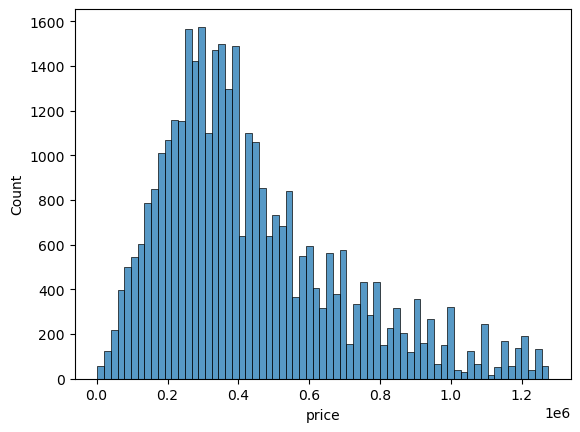

In [42]:
sns.histplot(data=df_mod, x="price")
plt.show()

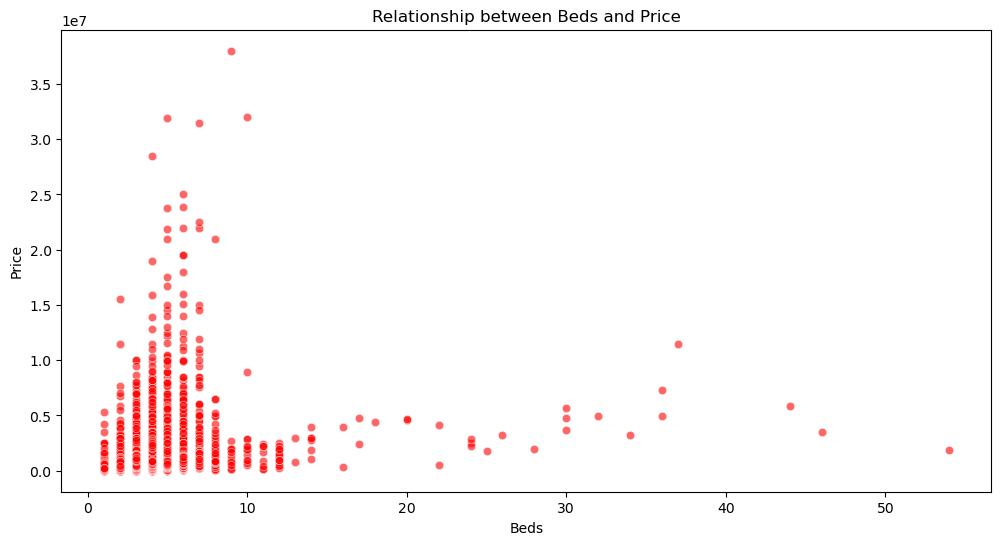

In [44]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='beds', y='price', data=df, color='red', alpha=0.6,)
plt.title('Relationship between Beds and Price')
plt.xlabel('Beds')
plt.ylabel('Price')
plt.show()

## Apply LSTM on the above data

In [45]:
# Normalize the data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['price_scaled'] = scaler.fit_transform(df[['price']])

In [46]:
import numpy as np

# Convert data into sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 10  # Number of past time steps to use
data = df['price_scaled'].values
X, y = create_sequences(data, sequence_length)

In [ ]:
#build LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Reshape X for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train the model
model.fit(X, y, epochs=50, batch_size=32, verbose=1)